# Import Library

In [1]:
# Data Loading
import xarray as xr  

# Data Processing
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Ignore warning messages
import warnings
warnings.filterwarnings(action='ignore')

# Data Load

In [2]:
# https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html
path = './sst.mnmean.nc'

ncfile = xr.open_dataset(path)
print(ncfile) # print dataset infomation 

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 1996)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-04-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    geospatial_lon_min:        -1.0
    geospatial_lon_max:        359.0

# Data Processing

In [3]:
# select variable
sst = ncfile.data_vars['sst']
print(sst.shape)  # [time, lat, lon]

(1996, 89, 180)


### simple low-pass filter (running mean)

In [4]:
# select domain & area average
nino3 = sst.sel(lon=slice(210,270), lat=slice(5,-5)).mean(dim=['lon', 'lat'])

# 19-month running mean
nino3_19mo_rm = nino3.rolling(time=19, center=True).mean()

In [5]:
def weighted_sum(x, axis):
    weight = [1/16, 4/16, 6/16, 4/16, 1/16]
    if x.shape[axis] == 5:
        return np.sum(x*weight, axis=axis)
    else:
        print('correct time interval')
        return np.nan

In [6]:
# 5-month weight running mean
nino3_5mo_wrm = nino3.rolling(time=5, center=True).reduce(weighted_sum)

### simple high-pass filter (removal of running mean)

In [7]:
nino3_minus_19mo_rm = nino3 - nino3_19mo_rm + nino3.mean(dim='time')
nino3_minus_19mo_rm.shape

(1996,)

# Visualization

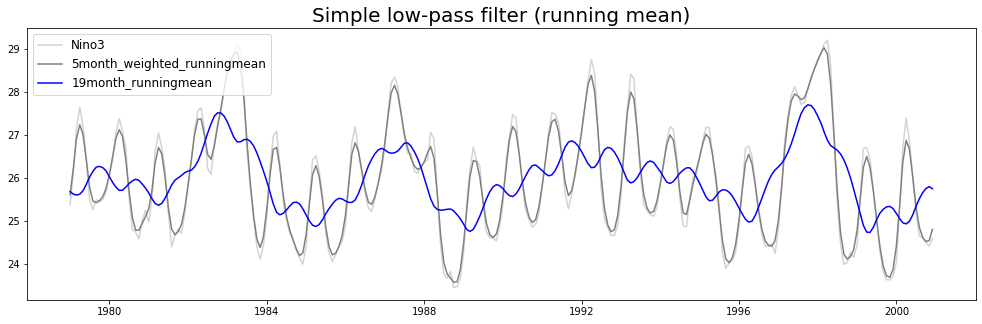

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17,5))

ax.plot(nino3.sel(time=slice('1979-01-01', '2000-12-01')).time, nino3.sel(time=slice('1979-01-01', '2000-12-01')), 
        color='lightgray', label='Nino3')
ax.plot(nino3.sel(time=slice('1979-01-01', '2000-12-01')).time, nino3_5mo_wrm.sel(time=slice('1979-01-01', '2000-12-01')), 
        color='gray', label='5month_weighted_runningmean')
ax.plot(nino3.sel(time=slice('1979-01-01', '2000-12-01')).time, nino3_19mo_rm.sel(time=slice('1979-01-01', '2000-12-01')), 
        color='blue', label='19month_runningmean')

ax.legend(fontsize='large', loc='upper left')
ax.set_title('Simple low-pass filter (running mean)', fontsize=20)

plt.show()

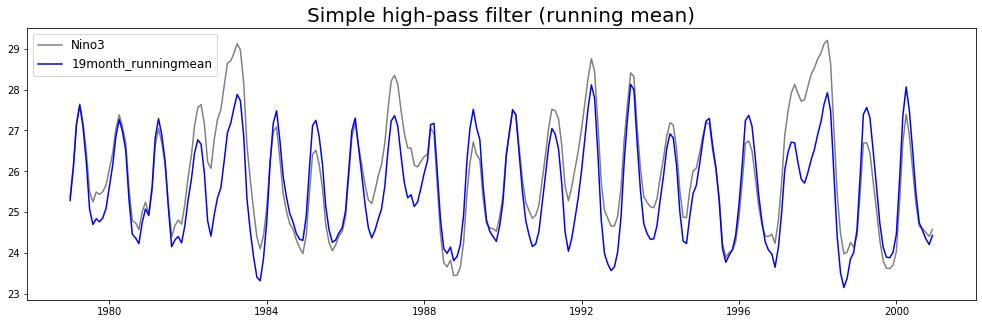

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17,5))

ax.plot(nino3.sel(time=slice('1979-01-01', '2000-12-01')).time, nino3.sel(time=slice('1979-01-01', '2000-12-01')), 
        color='gray', label='Nino3')
ax.plot(nino3.sel(time=slice('1979-01-01', '2000-12-01')).time, nino3_minus_19mo_rm.sel(time=slice('1979-01-01', '2000-12-01')), 
        color='blue', label='19month_runningmean')

ax.legend(fontsize='large', loc='upper left')
ax.set_title('Simple high-pass filter (running mean)', fontsize=20)

plt.show()